In [1]:
import torch
import torch.nn as nn
from tokenizers import Tokenizer , models, trainers, pre_tokenizers
from tokenizers.pre_tokenizers import Whitespace
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [9]:
corpus = [
    "artificial intelligence machine learning",
    "deep learning neural networks",
    "data science big data analytics",
    "machine learning algorithms"
]

In [10]:
with open("corpus_1.txt", "w", encoding = "utf-8") as f:
    for line in corpus:
        f.write(line + '\n')

In [41]:
#Train BPE Tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizers = Whitespace()
trainer = trainers.BpeTrainer(vocab_size = 100 , show_progress = True, special_tokens = ["[UNK]", "[CLS]", "[SEP]"])
tokenizer.train(["corpus_1.txt"], trainer)

output  = tokenizer.encode("machine learning algorithms")
print("TOKENS : ", output.tokens)
print("TOKEN_ids : ", output.ids)

TOKENS :  ['machine learning algor', 'it', 'hm', 's']
TOKEN_ids :  [89, 66, 65, 21]


In [42]:
# Embeddings
vocab_size = tokenizer.get_vocab_size()
embed_dim = 8
embedding = nn.Embedding(vocab_size, embed_dim)
token_ids = torch.tensor(output.ids)
embeds = embedding(token_ids)

print("Embeddding Shape :", embeds.shape)
print('Sample Embeddibngs:\n', embeds)

Embeddding Shape : torch.Size([4, 8])
Sample Embeddibngs:
 tensor([[-0.4753,  0.5707, -0.7384, -0.3651,  0.8203, -0.6461,  2.1833,  1.6933],
        [ 1.1562, -0.5387,  1.0715,  0.6076,  0.9974,  1.1800, -0.6836,  0.5098],
        [-0.2903,  1.0325,  0.5625, -0.7009,  1.2270, -0.1611,  1.4134,  0.3092],
        [-0.0051, -0.3076, -0.1808,  1.2713,  0.0528, -1.0164, -0.2762,  0.9969]],
       grad_fn=<EmbeddingBackward0>)


In [44]:
# Transfomer
class MiniTransfomer(nn.Module):
    def __init__(self, embed_dim , num_heads = 2):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim , num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim,embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim,embed_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1) # seq length , batch , embed_dim
        attn_out, _ = self.attn(x,x,x)
        x= attn_out + x # residual
        x = self.ff(x)+x
        return x.squeeze(1)

model = MiniTransfomer(embed_dim)

In [46]:
#Training loop
optimizer = optim.Adam(list(model.parameters())  + list(embedding.parameters()), lr= 0.01  )
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    optimizer.zero_grad()

    # recomute embeddings each epoch
    embeds = embedding(token_ids)
    inputs = embeds[:-1]
    targets = token_ids[1:]

    out = model(inputs)
    logits = out @ embedding.weight.T
    loss = loss_fn(logits,targets )

    loss.backward()
    optimizer.step()

    print(f"\n Epoch {epoch}")
    print("Transformer Output shape: ", out.shape)
    print("logits  shape: ", logits.shape)
    print("loss:", loss.item())


 Epoch 0
Transformer Output shape:  torch.Size([3, 8])
logits  shape:  torch.Size([3, 100])
loss: 5.584743976593018

 Epoch 1
Transformer Output shape:  torch.Size([3, 8])
logits  shape:  torch.Size([3, 100])
loss: 5.067567348480225

 Epoch 2
Transformer Output shape:  torch.Size([3, 8])
logits  shape:  torch.Size([3, 100])
loss: 4.581479549407959

 Epoch 3
Transformer Output shape:  torch.Size([3, 8])
logits  shape:  torch.Size([3, 100])
loss: 4.125224590301514

 Epoch 4
Transformer Output shape:  torch.Size([3, 8])
logits  shape:  torch.Size([3, 100])
loss: 3.7523269653320312

 Epoch 5
Transformer Output shape:  torch.Size([3, 8])
logits  shape:  torch.Size([3, 100])
loss: 3.4059360027313232

 Epoch 6
Transformer Output shape:  torch.Size([3, 8])
logits  shape:  torch.Size([3, 100])
loss: 3.097034454345703

 Epoch 7
Transformer Output shape:  torch.Size([3, 8])
logits  shape:  torch.Size([3, 100])
loss: 2.8243494033813477

 Epoch 8
Transformer Output shape:  torch.Size([3, 8])
logit

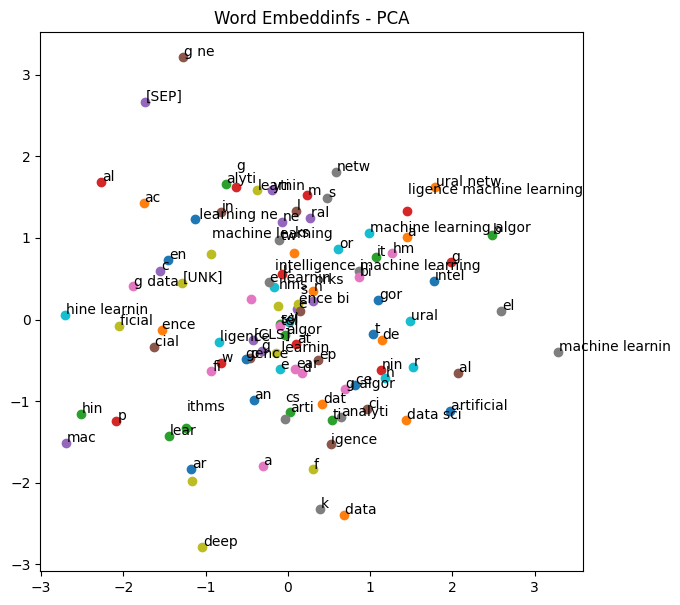

In [47]:
# Visulaize

final_embeds = embedding.weight.detach().numpy()

pca = PCA(n_components=2).fit_transform(final_embeds)

plt.figure(figsize= (7,7))

for word, idx in tokenizer.get_vocab().items():
    plt.scatter(pca[idx, 0], pca[idx,1])
    plt.text(pca[idx,0]+0.01, pca[idx,1]+0.01, word)
    plt.title("Word Embeddinfs - PCA")
plt.show()
